# <center> SubTask B: Answer Classification </center>

This subtask focuses on classifying the given answers into 3 categories : Non-Factual, Factual-True and Factual-False.

This work tries to find out whether adding user and length information improves model performance or not.

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tokenization

In [2]:
train = pd.read_csv('Answers_Train.csv')
cv = pd.read_csv('Answers_Dev.csv')
test = pd.read_csv('Answers_Test.csv')

In [3]:
train.isnull().sum() # checking for null values

Thread Sequence      0
Question Label       0
Question Subject     0
Question Body       38
Answer               0
Answer Label         0
UserID               0
dtype: int64

In [4]:
# dropping null data
train.drop('Question Body', axis = 1, inplace = True)
cv.drop('Question Body', axis = 1, inplace = True)

In [5]:
train.head()

,Thread Sequence,Question Label,Question Subject,Answer,Answer Label,UserID
0,Q272_R51,Factual,Qatar petroleum technical site interview?,If you have been invited for interview in Doha...,NonFactual,U178
1,Q272_R51,Factual,Qatar petroleum technical site interview?,the interviewing department will endorse their...,NonFactual,U459
2,Q273_R39,Factual,Vaccinations needed before i come to Doha?,Yes there are; though it varies depending on w...,True,U429
3,Q273_R39,Factual,Vaccinations needed before i come to Doha?,I suggest going to visit your local GP and men...,True,U1199
4,Q273_R39,Factual,Vaccinations needed before i come to Doha?,It depends what you have had already. You don'...,True,U237


In [6]:
train['Answer Label'].unique() # unique labels in the dataset

array(['NonFactual', 'True', 'False'], dtype=object)

In [8]:
def calc_char(x):
    '''Function to calculate the length of each question'''
    return len(x.split())

train['Sentence_Length'] = train['Answer'].apply(lambda x: calc_char(x))
cv['Sentence_Length'] = cv['Answer'].apply(lambda x: calc_char(x))
test['Sentence_Length'] = test['Answer'].apply(lambda x: calc_char(x))

In [9]:
# Mapping Label Values

label_mapper = {'NonFactual':0, 'True':1, 'False':2}

train['Answer Label'] = train['Answer Label'].map(label_mapper)
cv['Answer Label'] = cv['Answer Label'].map(label_mapper)
test['Answer Label'] = test['Answer Label'].map(label_mapper)

In [10]:
train.head() # sample data

,Thread Sequence,Question Label,Question Subject,Answer,Answer Label,UserID,Sentence_Length
0,Q272_R51,Factual,Qatar petroleum technical site interview?,If you have been invited for interview in Doha...,0,U178,48
1,Q272_R51,Factual,Qatar petroleum technical site interview?,the interviewing department will endorse their...,0,U459,48
2,Q273_R39,Factual,Vaccinations needed before i come to Doha?,Yes there are; though it varies depending on w...,1,U429,39
3,Q273_R39,Factual,Vaccinations needed before i come to Doha?,I suggest going to visit your local GP and men...,1,U1199,42
4,Q273_R39,Factual,Vaccinations needed before i come to Doha?,It depends what you have had already. You don'...,1,U237,114


### Standard Scaling Sentence Length

In [11]:
ss = StandardScaler()

train['Sentence_Length'] = ss.fit_transform(train['Sentence_Length'].values.reshape(-1, 1))
cv['Sentence_Length'] = ss.transform(cv['Sentence_Length'].values.reshape(-1, 1))
test['Sentence_Length'] = ss.transform(test['Sentence_Length'].values.reshape(-1, 1))

### Target Encoding User Information

In [12]:
print('Number of Unique users in the train set:', train['UserID'].nunique())

Number of Unique users in the train set: 332


In [13]:
te = TargetEncoder()

train_te_users = te.fit_transform(train['UserID'], train['Answer Label'])
cv_te_users = te.transform(cv['UserID'])
test_te_users = te.transform(test['UserID'])

## Modelling

In [14]:
# GPU memory growth setter
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

In [16]:
vocab_file = encoder.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = encoder.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
def tokz(X, max_len):
    '''Tokeinzer for BERT'''
    X_mask = np.zeros((X.shape[0], max_len))
    X_segment = np.zeros((X.shape[0], max_len))
    X_tokens = np.zeros((X.shape[0], max_len))

    for i in range(len(X)):
        tokens = tokenizer.tokenize(X.values[i])
        
        if len(tokens) >= (max_len - 2):         # truncating
            tokens = tokens[ 0 : (max_len-2)]
            
        tokens = ['[CLS]', *tokens, '[SEP]']
        
        mask = np.array([1] * len(tokens) + [0]*(max_len - len(tokens)))
        
        while(len(tokens) < max_len):           # padding
            tokens.append('[PAD]')

        tokens = np.array(tokenizer.convert_tokens_to_ids(tokens))
        segment = np.array([0] * max_len)
        
        X_mask[i] = mask
        X_segment[i] = segment
        X_tokens[i] = tokens
        
    return X_tokens, X_mask, X_segment

In [18]:
max_seq_length = 110 # Fixed sentence length for all answers

train_tokens, train_mask, train_segment = tokz(train['Answer'], max_seq_length)

cv_tokens, cv_mask, cv_segment = tokz(cv["Answer"], max_seq_length)

test_tokens, test_mask, test_segment = tokz(test["Answer"], max_seq_length)

In [20]:
# one hot encoding all labels
ohe = OneHotEncoder()

y_train_ohe = ohe.fit_transform(train['Answer Label'].values.reshape(-1,1)).toarray()
y_cv_ohe = ohe.transform(cv['Answer Label'].values.reshape(-1,1)).toarray()
y_test_ohe = ohe.transform(test['Answer Label'].values.reshape(-1,1)).toarray()

In [21]:
n_labels = train['Answer Label'].nunique()

## BERT Model without User Info

In [22]:
#BERT takes 3 inputs
#this is input words. Sequence of words represented as integers

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

densep = tf.keras.layers.Dense(768, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=42))(pooled_output)
output_ = tf.keras.layers.Dense(n_labels,activation = 'softmax')(densep)

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output_)

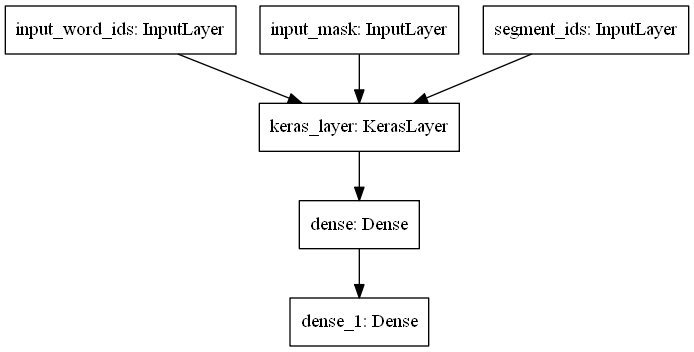

In [23]:
tf.keras.utils.plot_model(bert_model)

In [24]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 110)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 110)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 110)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [25]:
opt = tf.keras.optimizers.Adam(0.00001)
bert_model.compile(opt, 'categorical_crossentropy')

In [26]:
history = bert_model.fit(x = [train_tokens, train_mask ,train_segment], y = y_train_ohe, epochs = 20, 
                         batch_size = 16, verbose = 1, validation_data = ([cv_tokens, cv_mask ,cv_segment], y_cv_ohe))

Epoch 1/20
31/31 [==============================] - 27s 507ms/step - loss: 1.1255 - val_loss: 1.0724
Epoch 2/20
31/31 [==============================] - 14s 450ms/step - loss: 0.9958 - val_loss: 1.0600
Epoch 3/20
31/31 [==============================] - 14s 446ms/step - loss: 0.8203 - val_loss: 1.0710
Epoch 4/20
31/31 [==============================] - 14s 449ms/step - loss: 0.5476 - val_loss: 1.1855
Epoch 5/20
31/31 [==============================] - 14s 447ms/step - loss: 0.2912 - val_loss: 1.2870
Epoch 6/20
31/31 [==============================] - 14s 447ms/step - loss: 0.1596 - val_loss: 1.5117
Epoch 7/20
31/31 [==============================] - 14s 449ms/step - loss: 0.0929 - val_loss: 1.5600
Epoch 8/20
31/31 [==============================] - 14s 446ms/step - loss: 0.0392 - val_loss: 1.7545
Epoch 9/20
31/31 [==============================] - 14s 446ms/step - loss: 0.0269 - val_loss: 1.6644
Epoch 10/20
31/31 [==============================] - 14s 458ms/step - loss: 0.0181 - val_lo

In [27]:
# predicting probabilities
train_pred = bert_model.predict([train_tokens, train_mask ,train_segment])
cv_pred = bert_model.predict([cv_tokens, cv_mask ,cv_segment])
test_pred = bert_model.predict([test_tokens, test_mask ,test_segment])

In [28]:
# converting probabilities to labels
train_pred_final = []
for i in range(len(train)):
    train_pred_final.append(np.argmax(train_pred[i]))
    
cv_pred_final = []
for i in range(len(cv)):
    cv_pred_final.append(np.argmax(cv_pred[i]))
    
test_pred_final = []
for i in range(len(test)):
    test_pred_final.append(np.argmax(test_pred[i]))

In [29]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Answer Label'], train_pred_final)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Answer Label'], cv_pred_final)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Answer Label'], test_pred_final)*100, 2), "%")

Train Set Accuracy:  99.6 %
Dev Set Accuracy:  42.86 %
Test Set Accuracy:  50.32 %


In [28]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Answer Label'], train_pred_final)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Answer Label'], cv_pred_final)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Answer Label'], test_pred_final)*100, 2), "%")

Train Set Accuracy:  99.6 %
Dev Set Accuracy:  41.96 %
Test Set Accuracy:  61.61 %


In [29]:
print("Train Set F1-Score: ",np.round(f1_score(train['Answer Label'], train_pred_final, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Answer Label'], cv_pred_final, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Answer Label'], test_pred_final, average='macro'), 2))

Train Set F1-Score:  1.0
Dev Set F1-Score:  0.36
Test Set F1-Score:  0.38


## BERT Model with User Info

In [22]:
#BERT takes 3 inputs
#this is input words. Sequence of words represented as integers
input_user = tf.keras.layers.Input(shape = (1,))

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

densep = tf.keras.layers.Dense(768, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=42))(pooled_output)
#print(densep.shape)

dense1 = tf.keras.layers.Dense(768, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=42))(input_user)
#print(dense1.shape)
add = tf.keras.layers.Add()([densep, dense1])
#print(add.shape)
dense2 = tf.keras.layers.Dense(512, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=421))(add)

output_ = tf.keras.layers.Dense(n_labels,activation = 'softmax')(dense2)

bert_model = Model(inputs=[[input_word_ids, input_mask, segment_ids], input_user], outputs=output_)

In [23]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 110)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 110)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 110)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [24]:
opt = tf.keras.optimizers.Adam(0.00001)
bert_model.compile(opt, 'categorical_crossentropy')

In [25]:
history = bert_model.fit(x = [[train_tokens, train_mask ,train_segment], train_te_users], y = y_train_ohe, epochs = 20, 
                         batch_size = 16, verbose = 1, 
                         validation_data = ([[cv_tokens, cv_mask ,cv_segment], cv_te_users], y_cv_ohe))

Epoch 1/20
31/31 [==============================] - 25s 451ms/step - loss: 1.2427 - val_loss: 1.0907
Epoch 2/20
31/31 [==============================] - 14s 449ms/step - loss: 1.0265 - val_loss: 1.0945
Epoch 3/20
31/31 [==============================] - 14s 449ms/step - loss: 0.8527 - val_loss: 1.1626
Epoch 4/20
31/31 [==============================] - 14s 453ms/step - loss: 0.5166 - val_loss: 1.3129
Epoch 5/20
31/31 [==============================] - 14s 448ms/step - loss: 0.3828 - val_loss: 1.5118
Epoch 6/20
31/31 [==============================] - 14s 447ms/step - loss: 0.1628 - val_loss: 1.5738
Epoch 7/20
31/31 [==============================] - 14s 449ms/step - loss: 0.0481 - val_loss: 1.8061
Epoch 8/20
31/31 [==============================] - 14s 448ms/step - loss: 0.0306 - val_loss: 1.8443
Epoch 9/20
31/31 [==============================] - 14s 449ms/step - loss: 0.0209 - val_loss: 2.0045
Epoch 10/20
31/31 [==============================] - 14s 450ms/step - loss: 0.0227 - val_lo

In [26]:
# predicting probabilities
train_pred = bert_model.predict( [[train_tokens, train_mask ,train_segment], train_te_users])
cv_pred = bert_model.predict( [[cv_tokens, cv_mask ,cv_segment], cv_te_users])
test_pred = bert_model.predict( [[test_tokens, test_mask ,test_segment], test_te_users])

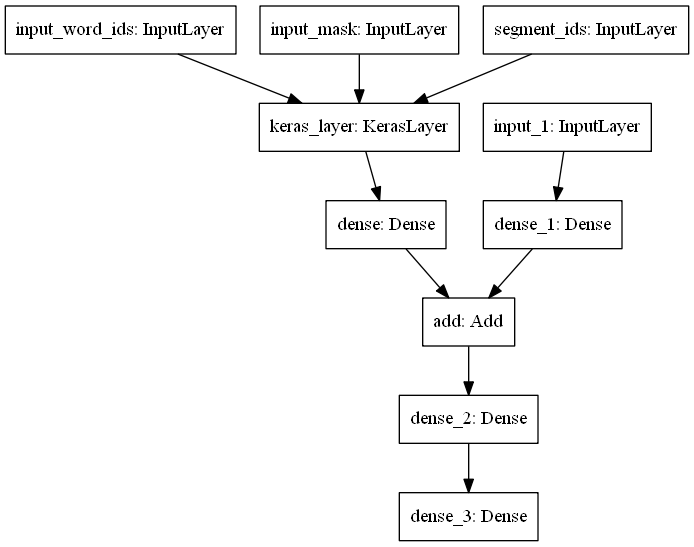

In [27]:
tf.keras.utils.plot_model(bert_model)

In [28]:
# converting probabilities to labels
train_pred_final = []
for i in range(len(train)):
    train_pred_final.append(np.argmax(train_pred[i]))
    
cv_pred_final = []
for i in range(len(cv)):
    cv_pred_final.append(np.argmax(cv_pred[i]))
    
test_pred_final = []
for i in range(len(test)):
    test_pred_final.append(np.argmax(test_pred[i]))

In [29]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Answer Label'], train_pred_final)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Answer Label'], cv_pred_final)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Answer Label'], test_pred_final)*100, 2), "%")

Train Set Accuracy:  99.6 %
Dev Set Accuracy:  48.21 %
Test Set Accuracy:  60.0 %


In [30]:
print("Train Set F1-Score: ",np.round(f1_score(train['Answer Label'], train_pred_final, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Answer Label'], cv_pred_final, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Answer Label'], test_pred_final, average='macro'), 2))

Train Set F1-Score:  1.0
Dev Set F1-Score:  0.41
Test Set F1-Score:  0.36


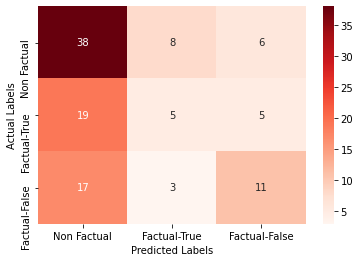

In [31]:
# confusion matrix
sns.heatmap(confusion_matrix(cv['Answer Label'], cv_pred_final), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Non Factual', 'Factual-True', 'Factual-False'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Non Factual', 'Factual-True', 'Factual-False'])

### BERT Model with Length Feature

In [33]:
#BERT takes 3 inputs
#this is input words. Sequence of words represented as integers
input_user = tf.keras.layers.Input(shape = (1,))

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

densep = tf.keras.layers.Dense(768, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=42))(pooled_output)
#print(densep.shape)

dense1 = tf.keras.layers.Dense(768, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=42))(input_user)
#print(dense1.shape)
add = tf.keras.layers.Add()([densep, dense1])
#print(add.shape)
dense2 = tf.keras.layers.Dense(512, activation='relu', 
                               kernel_initializer = tf.keras.initializers.he_normal(seed=421))(add)

output_ = tf.keras.layers.Dense(n_labels,activation = 'softmax')(dense2)

bert_model = Model(inputs=[[input_word_ids, input_mask, segment_ids], input_user], outputs=output_)

In [23]:
opt = tf.keras.optimizers.Adam(0.00001)
bert_model.compile(opt, 'categorical_crossentropy')

In [24]:
history = bert_model.fit(x = [[train_tokens, train_mask ,train_segment], train['Sentence_Length'].values], 
                         y = y_train_ohe, epochs = 20, 
                         batch_size = 16, verbose = 1, 
                         validation_data = ([[cv_tokens, cv_mask ,cv_segment], cv['Sentence_Length'].values], y_cv_ohe))

Epoch 1/20
31/31 [==============================] - 30s 507ms/step - loss: 1.1188 - val_loss: 1.1153
Epoch 2/20
31/31 [==============================] - 14s 447ms/step - loss: 1.0205 - val_loss: 1.0912
Epoch 3/20
31/31 [==============================] - 14s 446ms/step - loss: 0.8430 - val_loss: 1.0782
Epoch 4/20
31/31 [==============================] - 14s 446ms/step - loss: 0.6133 - val_loss: 1.2209
Epoch 5/20
31/31 [==============================] - 14s 446ms/step - loss: 0.3184 - val_loss: 1.2715
Epoch 6/20
31/31 [==============================] - 14s 446ms/step - loss: 0.1544 - val_loss: 1.4515
Epoch 7/20
31/31 [==============================] - 14s 446ms/step - loss: 0.1072 - val_loss: 1.6359
Epoch 8/20
31/31 [==============================] - 14s 446ms/step - loss: 0.0381 - val_loss: 1.7351
Epoch 9/20
31/31 [==============================] - 14s 446ms/step - loss: 0.0300 - val_loss: 1.8701
Epoch 10/20
31/31 [==============================] - 14s 446ms/step - loss: 0.0292 - val_lo

In [25]:
# predicting probabilities
train_pred = bert_model.predict( [[train_tokens, train_mask ,train_segment], train['Sentence_Length'].values])
cv_pred = bert_model.predict( [[cv_tokens, cv_mask ,cv_segment], cv['Sentence_Length'].values])
test_pred = bert_model.predict( [[test_tokens, test_mask ,test_segment], test['Sentence_Length'].values])

In [26]:
# converting probabilities to labels
train_pred_final = []
for i in range(len(train)):
    train_pred_final.append(np.argmax(train_pred[i]))
    
cv_pred_final = []
for i in range(len(cv)):
    cv_pred_final.append(np.argmax(cv_pred[i]))
    
test_pred_final = []
for i in range(len(test)):
    test_pred_final.append(np.argmax(test_pred[i]))

In [27]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Answer Label'], train_pred_final)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Answer Label'], cv_pred_final)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Answer Label'], test_pred_final)*100, 2), "%")

Train Set Accuracy:  99.6 %
Dev Set Accuracy:  40.18 %
Test Set Accuracy:  42.26 %


In [28]:
print("Train Set F1-Score: ",np.round(f1_score(train['Answer Label'], train_pred_final, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Answer Label'], cv_pred_final, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Answer Label'], test_pred_final, average='macro'), 2))

Train Set F1-Score:  1.0
Dev Set F1-Score:  0.4
Test Set F1-Score:  0.31
